Sames as training_mkl_04_cv except with much larger set of drugs to train on:

In [1]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_plotly
%run -m ipy_seaborn
%matplotlib inline
import tensorflow as tf
import edward as ed

from mgds.data_aggregation import api
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import data_type as dtyp
from mgds.data_modeling.nbfn import mkl as mkl
from mgds.data_modeling.nbfn import drugs as mgds_drugs
from mgds.data_modeling.nbfn import model_mkl04 as mklmodel
from mgds.data_modeling import constants as model_constants
from ml.api import trainer as ml_trainer

SEED = model_constants.SEED
RES_DIR = '/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large'

def rpath(filename):
    return os.path.join(RES_DIR, filename)

2017-04-17 16:56:12,988:DEBUG:requests.packages.urllib3.connectionpool: Starting new HTTPS connection (1): api.plot.ly


In [2]:
X_rppa, Y_rppa, df_rppa = mkl.get_tcga_modeling_data('brca')

2017-04-17 16:56:17,471:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/tcga_v1_raw-data-matrices.pkl"
2017-04-17 16:56:54,052:INFO:mgds.data_modeling.nbfn.mkl: Imputing 530 X values of 5406245
2017-04-17 16:57:01,921:INFO:mgds.data_modeling.nbfn.mkl: Imputing 0 Y values of 68107


In [75]:
X_rppa.head()

A1BG       A2M     A2ML1    A4GALT     A4GNT      AAAS  \
TCGA-A1-A0SH-01  0.870605  0.559730 -0.367295  0.328778  0.758833 -0.487438   
TCGA-A1-A0SJ-01  0.872559  1.102547 -0.148141  1.264884  0.666648 -1.213378   
TCGA-A1-A0SK-01 -1.013238 -1.560533 -0.437319 -1.815881 -0.616431  0.474611   
TCGA-A1-A0SO-01  2.024414 -1.528715 -0.209345 -1.922070 -0.421866 -0.455157   
TCGA-A2-A04N-01 -0.093212 -0.317896 -0.105897 -1.040180 -0.299182 -0.376301   

                     AACS     AADAC   AADACL2     AADAT    ...       ZSWIM7  \
TCGA-A1-A0SH-01 -0.367847 -0.381866  0.429928  0.491078    ...    -1.155395   
TCGA-A1-A0SJ-01 -0.492549  0.396224  0.215424  0.272124    ...     0.746362   
TCGA-A1-A0SK-01  2.052741 -1.359082  4.724143  1.757632    ...     0.648397   
TCGA-A1-A0SO-01 -1.216844 -0.127306 -0.205504  3.406434    ...     0.267998   
TCGA-A2-A04N-01 -1.045070 -0.420190 -0.094920  0.404800    ...     1.210438   

                   ZSWIM8     ZUFSP     ZWINT      ZXDC    ZYG11A    ZYG11B  \
TCGA-A1-A0SH-01 -0.594546 -0.706952 -1.039229 -0.944414 -1.075430  0.448913   
TCGA-A1-A0SJ-01  0.208179  1.562000 -0.486746 -0.965194 -0.809305  0.319753   
TCGA-A1-A0SK-01  0.106865  1.162083  1.161790  0.648071  0.299535  1.058283   
TCGA-A1-A0SO-01 -0.075633  1.003455  0.584886 -2.791125  0.129313  1.570114   
TCGA-A2-A04N-01 -0.350424  0.544582 -0.406891 -1.094822 -0.220411 -0.188337   

                      ZYX     ZZEF1      ZZZ3  
TCGA-A1-A0SH-01  1.112932  0.073506 -0.164467  
TCGA-A1-A0SJ-01 -0.747920 -0.594728 -0.838861  
TCGA-A1-A0SK-01 -2.988537 -0.273973  0.356013  
TCGA-A1-A0SO-01 -1.281026 -1.388816 -0.516795  
TCGA-A2-A04N-01 -2.468727  0.270728  1.253623  

[5 rows x 13415 columns]

In [72]:
Y_rppa.head()

RPPA               ABL1   ACACA  ACVRL1    ADAR    AKT1    AKT2    AKT3  \
TCGA-A1-A0SH-01  0.1414  1.7752 -0.2407 -0.7190  0.7654  0.7654  0.7654   
TCGA-A1-A0SJ-01 -1.0458  0.3505 -0.1300 -0.5828  0.0138  0.0138  0.0138   
TCGA-A1-A0SK-01 -0.3807 -0.9959 -0.6685  0.8784 -0.3473 -0.3473 -0.3473   
TCGA-A1-A0SO-01 -0.2390  0.6525 -0.7010  0.9611  1.0870  1.0870  1.0870   
TCGA-A2-A04N-01  0.6021 -1.1306  0.8882 -0.4393 -0.0384 -0.0384 -0.0384   

RPPA              ANXA1   ANXA7      AR   ...      TSC2  TUBA1B   WWTR1  \
TCGA-A1-A0SH-01  0.4182 -0.5345  0.0724   ...   -0.1415 -0.4113 -0.4335   
TCGA-A1-A0SJ-01 -0.3603 -0.0939 -0.0813   ...   -0.9173  0.6643 -0.2490   
TCGA-A1-A0SK-01  2.9900 -1.6245 -1.5832   ...   -0.8886  1.1055 -1.0175   
TCGA-A1-A0SO-01 -0.0437 -0.9322 -1.8314   ...    0.2309  2.1998  0.0856   
TCGA-A2-A04N-01  1.0340  0.7484 -0.1937   ...   -0.9436  0.1995  0.6093   

RPPA               XBP1   XRCC1   XRCC5    YAP1    YBX1   YWHAB   YWHAZ  
TCGA-A1-A0SH-01 -0.1147 -0.2647  0.2348 -0.2456 -0.1099 -0.3763 -0.6884  
TCGA-A1-A0SJ-01 -0.3291 -0.9635 -0.5291  0.7098 -0.0326  0.5145  0.2628  
TCGA-A1-A0SK-01 -0.3598  1.9310  1.0458 -1.1998 -0.5646 -0.2280  1.2399  
TCGA-A1-A0SO-01 -0.1162  1.7869  1.4647 -0.6514  0.2517 -1.1367 -0.2812  
TCGA-A2-A04N-01 -0.3324 -0.7949 -0.9460  0.4596 -0.7023 -0.1742  0.4311  

[5 rows x 169 columns]

In [3]:
target_drugs = list(np.unique(mgds_drugs.GDSC_PAPER_DRUGS + mgds_drugs.DEFAULT_DRUGS))
target_drugs[:10]

['17AAG',
 '5FLUOROURACIL',
 '5Z7OXOZEAENOL',
 '681640',
 'A443654',
 'A770041',
 'AC220',
 'AFATINIB',
 'AG014699',
 'AICAR']

In [80]:
len(target_drugs)

233

In [4]:
# import imp
# imp.reload(mkl)

In [4]:
X_drug, Y_drug = mkl.get_rx_modeling_data(
    drugs=target_drugs, genes=X_rppa.columns.tolist(), 
    ge_src=src.CCLE_v1, site='BREAST'
)
# X_drug, Y_drug = mkl.get_rx_modeling_data(
#     drugs=target_drugs, genes=X_rppa.columns.tolist(), 
#     ge_src=src.GDSC_v2, site='BREAST'
# )
#X_drug, Y_drug = mkl.get_rx_modeling_data(drugs=target_drugs, genes=X_rppa.columns.tolist(), ge_src='agg')

2017-04-17 16:57:01,951:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/mgds_v1_raw-features.pkl"
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/ipykernel/ipkernel.py:196: PerformanceWarning:

indexing past lexsort depth may impact performance.

2017-04-17 16:57:23,519:INFO:mgds.data_modeling.nbfn.mkl: Removing 37 drugs of 233 due to having more than 30.0% null records


[Remove X records with null X values] Records before = 1473, Records after = 967, Records removed = 506 (%34.35)
[Remove Y records with null X values] Records before = 1473, Records after = 967, Records removed = 506 (%34.35)
[Remove X records with null Y values] Records before = 967, Records after = 639, Records removed = 328 (%33.92)
[Remove Y records with null Y values] Records before = 967, Records after = 639, Records removed = 328 (%33.92)


In [73]:
X_drug.head()

A1BG     A2M   A2ML1  A4GALT   A4GNT  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                           
AU565             BREAST            -0.7203  0.2146  1.4553 -0.6623 -0.5925   
BT20              BREAST            -0.7066 -0.5051  0.6345 -0.9157  0.5173   
BT474             BREAST            -1.2665 -0.4155 -0.3491 -0.2819 -0.3083   
BT483             BREAST             0.6909 -0.2528 -0.1435  0.7511 -0.9741   
BT549             BREAST             1.3433 -0.3780 -0.1978  0.1811 -0.4132   

                                       AAAS    AACS   AADAC  AADACL2   AADAT  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                            
AU565             BREAST             1.8444  1.6000 -0.0267  -0.5664 -0.6264   
BT20              BREAST            -0.0836  0.8155 -0.4130   0.6665 -1.7076   
BT474             BREAST            -0.5347  0.1965 -0.3221  -0.6366 -0.1124   
BT483             BREAST            -0.9885  0.6537 -0.2252  -0.0677  0.2028   
BT549             BREAST             0.5231 -2.0494 -0.5520   0.4526 -1.0863   

                                      ...    ZSWIM7  ZSWIM8   ZUFSP   ZWINT  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS   ...                                     
AU565             BREAST              ...   -0.2793  1.1833 -1.2331  0.5023   
BT20              BREAST              ...    0.8696 -0.6261  1.2621  0.1898   
BT474             BREAST              ...    0.4439 -0.2313  0.9465  0.5027   
BT483             BREAST              ...   -1.5697  1.1608 -2.0656 -0.2537   
BT549             BREAST              ...    0.0519  2.3173 -1.1863  0.4942   

                                       ZXDC  ZYG11A  ZYG11B     ZYX   ZZEF1  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                           
AU565             BREAST            -0.4632 -0.6045 -0.2863  1.3912  0.7169   
BT20              BREAST             0.4799  1.4424 -0.7454  0.7373  0.4954   
BT474             BREAST             0.7172  0.3457  0.1203 -0.7041  0.0264   
BT483             BREAST             0.5563  2.1898 -0.2794 -0.4491 -1.5841   
BT549             BREAST            -1.3656  1.4917 -0.7009  1.2634  1.5981   

                                       ZZZ3  
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS          
AU565             BREAST            -1.8807  
BT20              BREAST             0.5627  
BT474             BREAST             0.1635  
BT483             BREAST            -2.1715  
BT549             BREAST             0.1064  

[5 rows x 13415 columns]

In [74]:
Y_drug.head()

Drug                                    17AAG  5FLUOROURACIL  5Z7OXOZEAENOL  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                           
AU565             BREAST            -2.239748       4.687255            NaN   
BT20              BREAST            -0.867087       5.330484       1.131463   
BT474             BREAST            -3.320525       3.677684       0.913706   
BT483             BREAST             0.356745       2.868350       1.831044   
BT549             BREAST            -1.858953            NaN       0.443387   

Drug                                   681640     AC220  AFATINIB  AG014699  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                           
AU565             BREAST             3.295951  1.386408 -1.275230  2.383220   
BT20              BREAST             2.167905  2.516425  3.002986  3.664450   
BT474             BREAST             3.432221  2.277451  0.222930  2.769537   
BT483             BREAST             3.291616  3.507311  6.779484  5.731183   
BT549             BREAST             3.207555       NaN  3.938038  3.743025   

Drug                                     AICAR  AKTINHIBITORVIII    AMG706  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                          
AU565             BREAST              5.744526          0.062734  0.757001   
BT20              BREAST              7.452440          1.313557  3.961929   
BT474             BREAST              9.179100          2.245198  3.686576   
BT483             BREAST             11.427978          3.999166  5.239431   
BT549             BREAST              8.864872               NaN  3.818830   

Drug                                   ...      XMD1499   XMD1527    XMD892  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS    ...                                    
AU565             BREAST               ...     5.086311  4.649195  3.280698   
BT20              BREAST               ...     5.602609  5.456034  4.583927   
BT474             BREAST               ...     5.329311  5.332276  1.395726   
BT483             BREAST               ...     6.643063  6.968761  6.779484   
BT549             BREAST               ...          NaN       NaN       NaN   

Drug                                   Y39983    YK4279     YM155  YM201636  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                           
AU565             BREAST             3.555993       NaN -4.782417  1.160961   
BT20              BREAST             4.854689  2.036492 -5.104088  2.885133   
BT474             BREAST             5.004309       NaN -2.998412  1.751956   
BT483             BREAST             6.087685  6.227111 -3.228855  2.905473   
BT549             BREAST                  NaN  1.350370       NaN       NaN   

Drug                                     ZG10  ZM447439   ZSTK474  
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                
AU565             BREAST             1.089226  2.760714  0.967897  
BT20              BREAST             5.069711  2.754761  0.587281  
BT474             BREAST             1.059341  4.027359 -0.664411  
BT483             BREAST             5.500267  5.363060 -1.034718  
BT549             BREAST                  NaN  3.268785       NaN  

[5 rows x 196 columns]

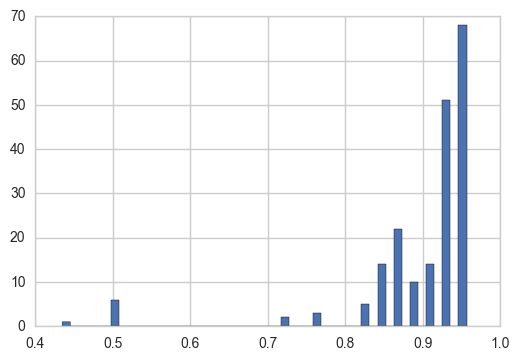

In [5]:
(Y_drug.notnull().sum(axis=0) / len(Y_drug)).hist(bins=50)

In [6]:
X_drug.shape, Y_drug.shape

((46, 13415), (46, 196))

In [7]:
X_rppa.shape, Y_rppa.shape

((403, 13415), (403, 169))

In [8]:
df_rppa.shape

(1105, 90637)

In [9]:
np.any(X_drug.isnull())

False

In [10]:
Y_drug.isnull().sum().sum() / Y_drug.values.ravel().shape[0]

0.098491570541259982

In [11]:
from sklearn.preprocessing import Imputer
Y_drug_imp = pd.DataFrame(Imputer(strategy='mean').fit_transform(Y_drug), index=Y_drug.index, columns=Y_drug.columns)

In [12]:
np.any(Y_drug_imp.isnull())

False

In [13]:
np.any(X_rppa.isnull())

False

In [14]:
np.any(Y_rppa.isnull())

False

# Modeling

In [16]:
# import imp
# imp.reload(mklmodel)
# imp.reload(ed_models)

In [17]:
# from ml.tensorflow import utilities as tf_utils
# tf.reset_default_graph()
# v = tf.contrib.distributions.StudentT(df=3., mu=0., sigma=.1).sample(100000)
# ax = pd.Series(tf_utils.tf_eval(v)).hist(bins=50)
# ax.set_yscale('symlog')

In [31]:
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from ml.edward import models as ed_models
from ml.api import trainer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

def get_mkl_model(i):
    tf.reset_default_graph()
    model = mklmodel.MTKLModel(X_rppa.values, Y_rppa.values, gamma=None, print_kernel_stats=False)
    est = ed_models.BayesianModelEstimator(
        model, n_collect=1, n_print_progress=100, random_state=SEED, 
        fail_if_not_converged=False, max_steps=2500,
        inference_fn=ed.MAP
    )
    est.set_log_dir('/tmp/mkl4cv/{}'.format(i))
    return est
    
    
ests = {
    'ridge': lambda i: Pipeline([
        ('scale', StandardScaler()),
        ('est', MultiOutputRegressor(RidgeCV(alphas=np.logspace(-3, 6, 10))))
    ]),
    'pcareg': lambda i: Pipeline([
        ('scale', StandardScaler()),
        ('pca', PCA(n_components=10)),
        ('est', MultiOutputRegressor(LinearRegression()))
    ]),
    'mkl': get_mkl_model,
    'baseline': lambda i: MultiOutputRegressor(DummyRegressor(strategy='mean'))
}

cv = KFold(n_splits=5, random_state=SEED, shuffle=True).split(X_drug)

def fit_fn(est_name, est, X_train, Y_train, X_test, Y_test, fold):
    if est_name == 'mkl':
        est = est.fit(X_train.values, Y_train.values)
        return est
    else:
        return est.fit(X_train, Y_train)

config = trainer.TrainerConfig(refit=True, model_fit_fn=fit_fn)
cv_trainer = trainer.Trainer(config)

In [32]:
! rm -rf /tmp/mkl4cv/*
train_res = cv_trainer.train_regressors(X_drug, Y_drug_imp, ests, cv)

2017-04-17 17:09:52,830:INFO:ml.model.log: Running model baseline (DummyRegressor) on fold 1 ==> dim(X_train) = (36, 13415), dim(X_test) = (10, 13415), dim(Y_train) = (36, 196), dim(Y_test) = (10, 196)
2017-04-17 17:09:52,909:INFO:ml.model.log: Running model mkl (BayesianModelEstimator) on fold 1 ==> dim(X_train) = (36, 13415), dim(X_test) = (10, 13415), dim(Y_train) = (36, 196), dim(Y_test) = (10, 196)


Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-04-17 17:09:55,422:INFO:root: On iteration 0 of at most 2500 (loss = 3859303.5, loss change = None)
2017-04-17 17:09:56,064:INFO:root: On iteration 100 of at most 2500 (loss = 2478864.5, loss change = -6288.35009765625)
2017-04-17 17:09:56,592:INFO:root: On iteration 200 of at most 2500 (loss = 2006392.25, loss change = -4357.2001953125)
2017-04-17 17:09:57,083:INFO:root: On iteration 300 of at most 2500 (loss = 1649639.875, loss change = -3303.85009765625)
2017-04-17 17:09:57,697:INFO:root: On iteration 400 of at most 2500 (loss = 1379388.875, loss change = -2502.58740234375)
2017-04-17 17:09:58,236:INFO:root: On iteration 500 of at most 2500 (loss = 1172497.5, loss change = -1934.112548828125)
2017-04-17 17:09:58,786:INFO:root: On iteration 600 of at most 2500 (loss = 1011572.125, loss change = -1512.0687255859375)
2017-04-17 17:09:59,329:INFO:root: On iteration 700 of at most 2500 (loss = 884521.125, loss change = -1205.34375)
2017-04-17 17:09:59,853:INFO:root: On iteration 800

Beginning model refitting


2017-04-17 17:11:22,768:INFO:root: On iteration 0 of at most 2500 (loss = 3862315.75, loss change = None)
2017-04-17 17:11:23,325:INFO:root: On iteration 100 of at most 2500 (loss = 2493613.25, loss change = -5985.0)
2017-04-17 17:11:23,806:INFO:root: On iteration 200 of at most 2500 (loss = 2027933.75, loss change = -4312.6376953125)
2017-04-17 17:11:24,275:INFO:root: On iteration 300 of at most 2500 (loss = 1674354.25, loss change = -3278.89990234375)
2017-04-17 17:11:24,746:INFO:root: On iteration 400 of at most 2500 (loss = 1405186.125, loss change = -2509.0)
2017-04-17 17:11:25,214:INFO:root: On iteration 500 of at most 2500 (loss = 1198258.0, loss change = -1938.2750244140625)
2017-04-17 17:11:25,681:INFO:root: On iteration 600 of at most 2500 (loss = 1036676.3125, loss change = -1523.0999755859375)
2017-04-17 17:11:26,151:INFO:root: On iteration 700 of at most 2500 (loss = 908778.1875, loss change = -1215.324951171875)
2017-04-17 17:11:26,619:INFO:root: On iteration 800 of at mo

In [33]:
from ml.api.results import predictions
d_pred = predictions.extract(train_res)
d_pred_melt = predictions.melt(train_res, d_pred)
d_pred_melt.head()

Actual  Fold     Model  Predicted  \
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                        
AU565             BREAST            -2.239748     1  baseline   -0.82205   
BT20              BREAST            -0.867087     1  baseline   -0.82205   
EFM19             BREAST            -0.957216     1  baseline   -0.82205   
HCC1500           BREAST             0.844980     1  baseline   -0.82205   
HCC1569           BREAST            -0.146932     1  baseline   -0.82205   

                                      Task  
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS         
AU565             BREAST             17AAG  
BT20              BREAST             17AAG  
EFM19             BREAST             17AAG  
HCC1500           BREAST             17AAG  
HCC1569           BREAST             17AAG

In [34]:
from ml.api.results import properties
est = properties.extract_refit_model_map(train_res)['mkl']

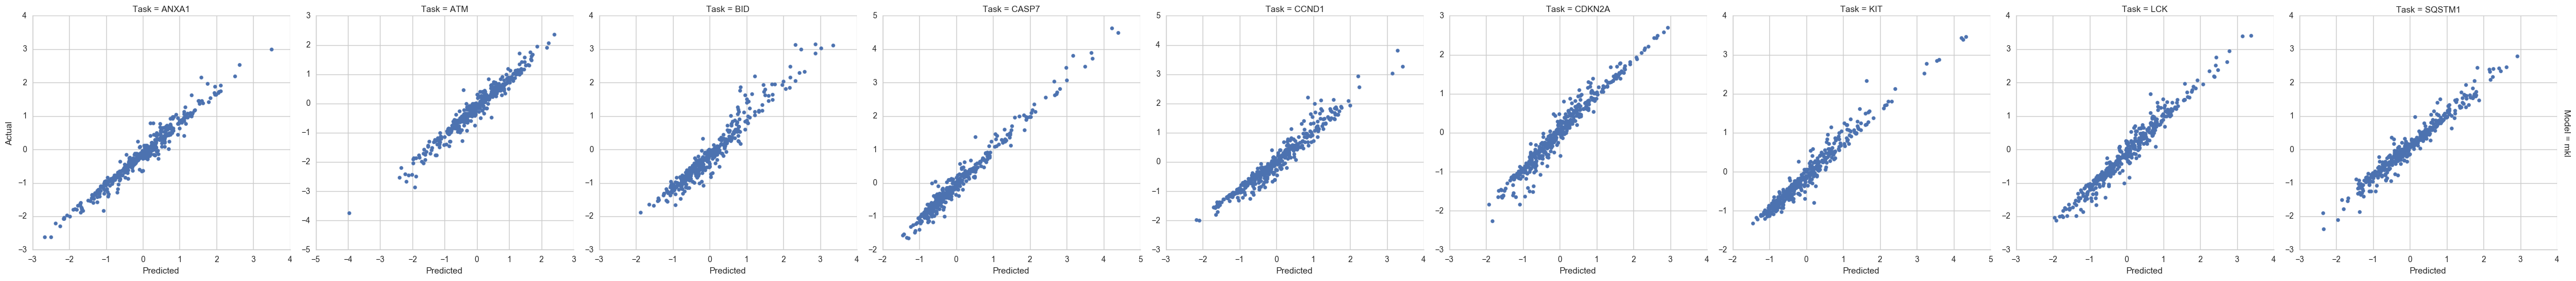

In [150]:
# Predictions on RPPA training data
Yp = pd.DataFrame(est.clf.get_tensor('qYR'), index=Y_rppa.index, columns=Y_rppa.columns)
d_pred_train = mkl.stack_predictions(Yp, Y_rppa).reset_index().assign(Model='mkl', Fold=0).rename(columns={'Pred': 'Predicted'})
tasks = d_pred_train['Task'].sample(n=10, random_state=SEED).values
g = predictions.visualize(train_res, d_pred_train[d_pred_train['Task'].isin(tasks)], share_axes=False)
g.savefig(rpath('pred_train_rppa.png'))

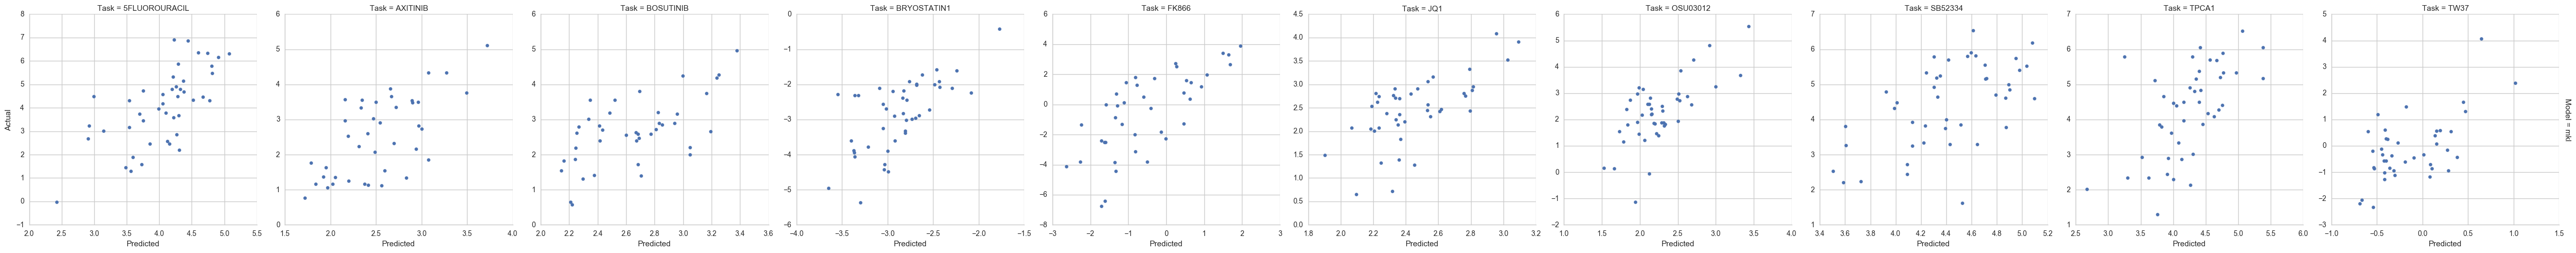

In [36]:
# Predictions on drug training data
Yp = est.clf.predict(X_drug.values)
d_pred_train = mkl.stack_predictions(Yp, Y_drug).reset_index().assign(Model='mkl', Fold=0).rename(columns={'Pred': 'Predicted'})
tasks = d_pred_train['Task'].sample(n=10, random_state=SEED).values
g = predictions.visualize(train_res, d_pred_train[d_pred_train['Task'].isin(tasks)], share_axes=False)
g.savefig(rpath('pred_train_drug.png'))

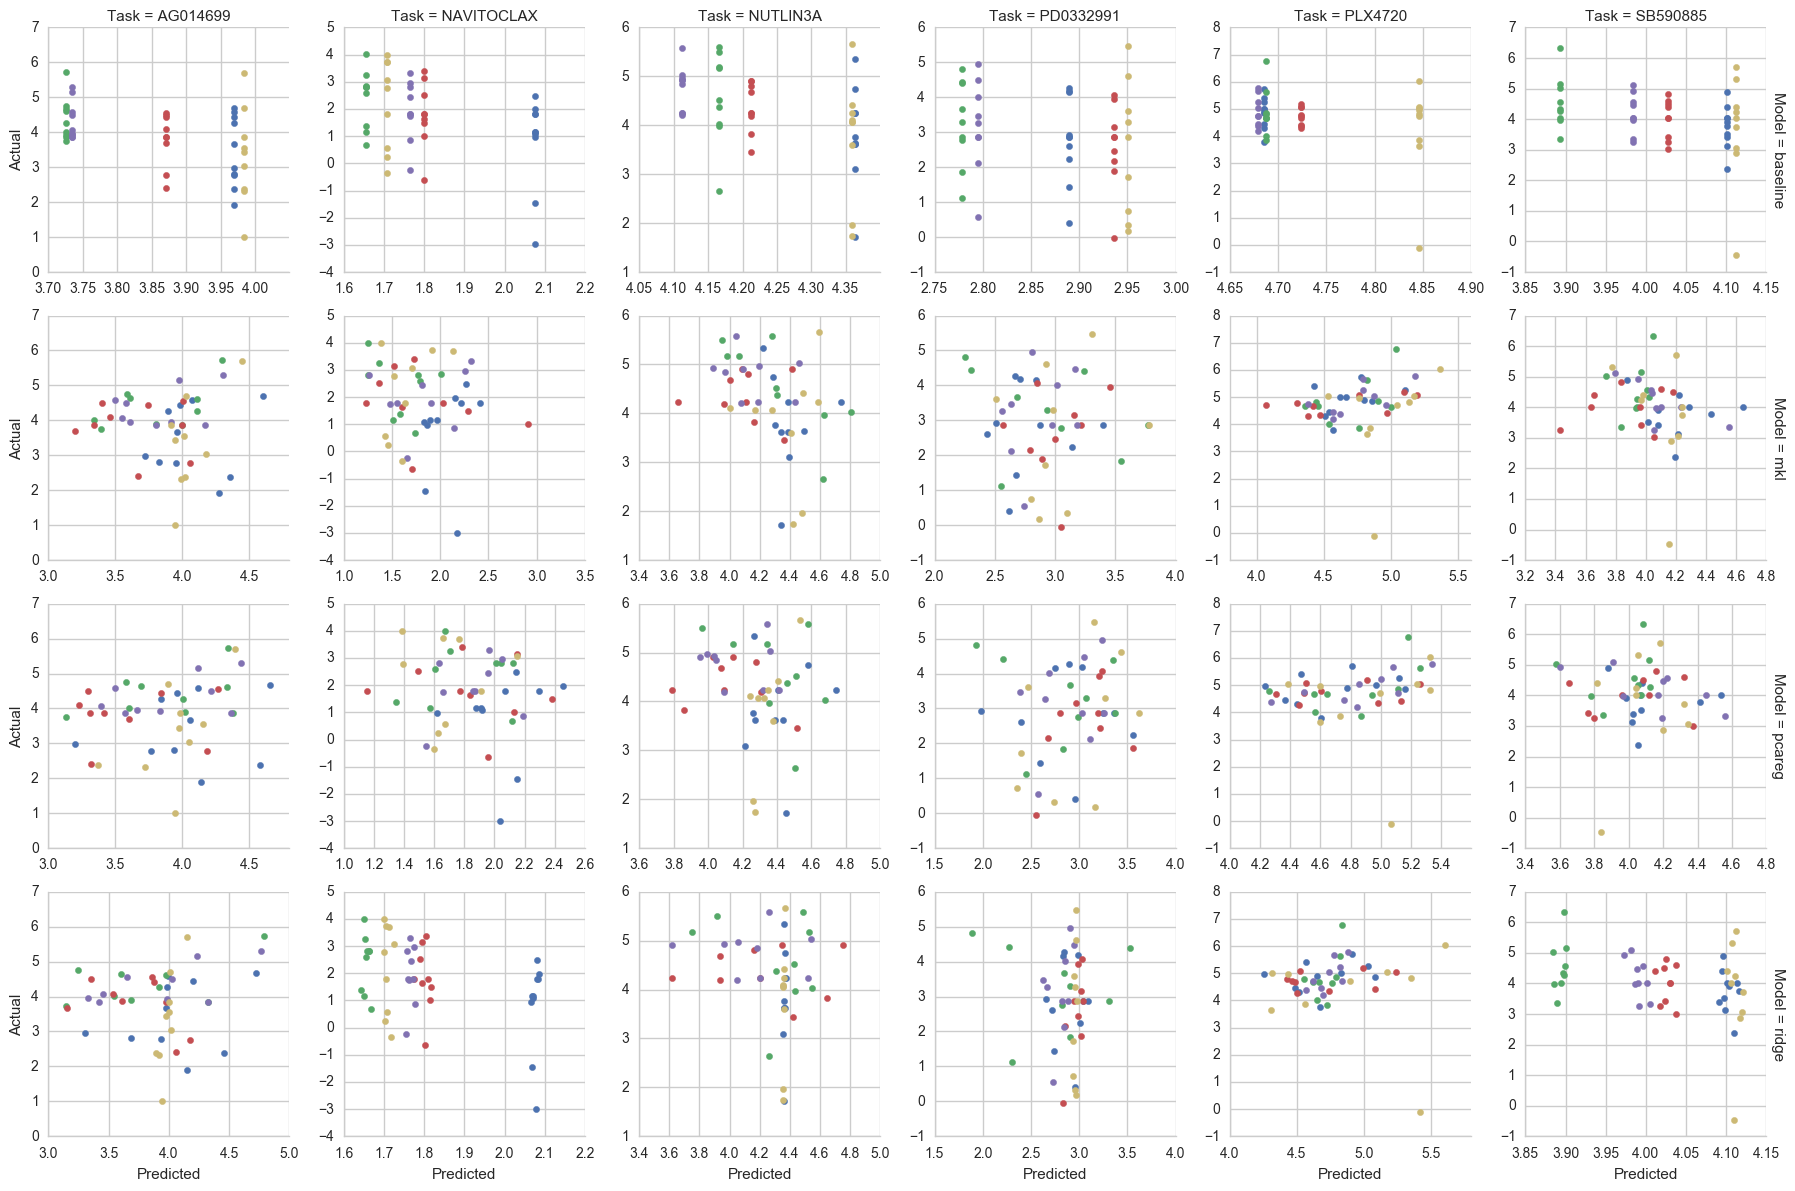

In [37]:
#tasks = d_pred_melt['Task'].sample(n=10).values
tasks = mgds_drugs.DEFAULT_DRUGS
predictions.visualize(train_res, d_pred_melt[d_pred_melt['Task'].isin(tasks)], share_axes=False, figsize=3)

In [38]:
from ml.api.results import performance
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr

def score_fn(y_true, y_pred):
    return {
        'pearson': y_true.corr(y_pred, method='pearson'),
        'spearman': y_true.corr(y_pred, method='spearman'),
        'r2_score': r2_score(y_true, y_pred),
        'pearson_p': pearsonr(y_true, y_pred)[1],
        'spearman_p': spearmanr(y_true, y_pred)[1]
    }
d_score = performance.extract(train_res, d_pred, score_fn, by_fold=False)
d_score = performance.melt(d_score)
d_score.head()

Model Fold   Task      Metric     Value
0  baseline  All  17AAG     pearson -0.290003
1  baseline  All  17AAG   pearson_p  0.050582
2  baseline  All  17AAG    r2_score -0.047791
3  baseline  All  17AAG    spearman -0.307595
4  baseline  All  17AAG  spearman_p  0.037570

In [25]:
from py_utils import plotly_utils
figs = performance.visualize(d_score, separate_by='Metric', kind='scatter', auto_plot=False)
for metric in figs:
    filename = rpath('perf_scatter_{}.html'.format(metric))
    plty.offline.plt(figs[metric], filename=filename)
    print(filename)
[plotly_utils.iplot(fig) for fig in figs.values()]

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large2/perf_scatter_pearson.html
/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large2/perf_scatter_r2_score.html
/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large2/perf_scatter_spearman_p.html
/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large2/perf_scatter_pearson_p.html
/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large2/perf_scatter_spearman.html


[None, None, None, None, None]

In [39]:
def plot_performance_metric(d_score, metric=None, plot_in_notebook=False):
    title = 'Performance Scores'
    if metric is not None:
        d_score = d_score[d_score['Metric'] == metric]
        title = metric
    
    fig = performance.visualize(d_score, separate_by=None, auto_plot=False, layout_kwargs={'title': title})['All']
    filename = rpath('perf_box_{}.html'.format(metric if metric else 'all'))
    plty.offline.plt(fig, filename=filename)
    print(filename)
    if plot_in_notebook:
        plty.offline.iplt(fig)

In [40]:
plot_performance_metric(d_score, plot_in_notebook=True)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large2/perf_box_all.html


In [41]:
plot_performance_metric(d_score, metric='pearson')

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large2/perf_box_pearson.html


In [42]:
plot_performance_metric(d_score, metric='spearman')

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large2/perf_box_spearman.html


In [43]:
plot_performance_metric(d_score, metric='pearson_p')

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large2/perf_box_pearson_p.html


# Drug Selection

Based on performance above:

In [44]:
d_score.head()

Model Fold   Task      Metric     Value
0  baseline  All  17AAG     pearson -0.290003
1  baseline  All  17AAG   pearson_p  0.050582
2  baseline  All  17AAG    r2_score -0.047791
3  baseline  All  17AAG    spearman -0.307595
4  baseline  All  17AAG  spearman_p  0.037570

In [45]:
def get_most_predictable_tasks(metric, pvalue):
    assert np.all(d_score['Fold'] == 'All')
    d_top_perf = d_score.set_index(['Model', 'Task', 'Metric'])['Value'].unstack()
    d_top_perf = d_top_perf[(d_top_perf[metric] >= 0) & (d_top_perf['{}_p'.format(metric)] <= pvalue)]
    return d_top_perf
d_top_perf = get_most_predictable_tasks('pearson', .15)
d_top_perf

Metric                  pearson     pearson_p  r2_score  spearman  \
Model  Task                                                         
mkl    AFATINIB        0.539505  1.092578e-04  0.278594  0.455252   
       AP24534         0.284167  5.562787e-02  0.073473  0.301672   
       AT7519          0.440943  2.160982e-03  0.178661  0.488883   
       AZD7762         0.581573  2.248304e-05  0.331626  0.537491   
       BLEOMYCIN50UM   0.584483  1.998955e-05  0.329607  0.597243   
       BMS345541       0.360409  1.387602e-02  0.121974  0.391748   
       BMS708163       0.239966  1.082070e-01  0.051523  0.264911   
       BX795           0.469983  9.822539e-04  0.217934  0.454007   
       BX912           0.423575  3.354532e-03  0.176508  0.337722   
       CAMPTOTHECIN    0.289354  5.112479e-02  0.082803  0.214107   
       CEP701          0.309706  3.621329e-02  0.094008  0.230036   
       CETUXIMAB       0.633628  2.282704e-06  0.358852  0.657637   
       CH5424802       0.378464  9.500737e-03  0.134294  0.298958   
       CHIR99021       0.293577  4.767958e-02  0.081712  0.345034   
       CISPLATIN       0.341803  2.007559e-02  0.115845  0.297577   
       CP724714        0.414884  4.145201e-03  0.171930  0.356566   
       DOCETAXEL       0.335223  2.276489e-02  0.109755  0.186140   
       FK866           0.245470  1.001125e-01  0.045646  0.208057   
       GSK1070916      0.501590  3.834867e-04  0.235562  0.489315   
       GSK1904529A     0.303098  4.060092e-02  0.091362  0.166518   
       GSK690693       0.251850  9.132258e-02  0.054876  0.376303   
       GW2580          0.473052  9.000415e-04  0.186276  0.342380   
       HG511301        0.441301  2.140924e-03  0.189793  0.341414   
       IBET762         0.250518  9.310710e-02  0.061825  0.244411   
       KIN001055       0.238698  1.101402e-01  0.054327  0.185266   
       KIN001102       0.305895  3.869320e-02  0.088123  0.417713   
       KIN001236       0.322760  2.868818e-02  0.099749  0.322427   
       KIN001270       0.479624  7.443275e-04  0.201176  0.406735   
       LENALIDOMIDE    0.325547  2.726310e-02  0.103878  0.196574   
       LY317615        0.252465  9.050829e-02  0.063331  0.316137   
       MK2206          0.304250  3.980659e-02  0.086955  0.279046   
       MLN4924         0.280589  5.891669e-02  0.078243  0.307573   
       MPS1IN1         0.284647  5.519815e-02  0.074362  0.237257   
       NPK76II721      0.488278  5.762127e-04  0.216324  0.409880   
       OLAPARIB        0.400570  5.805240e-03  0.159328  0.360321   
       PD0325901       0.306119  3.854412e-02  0.093444  0.410021   
       PFI1            0.588910  1.667976e-05  0.273491  0.477580   
       PHA793887       0.442267  2.087763e-03  0.186945  0.449701   
       PIPERLONGUMINE  0.329325  2.542576e-02  0.105968  0.225313   
       QLXII47         0.234172  1.172576e-01  0.052878  0.299732   
       RDEA119         0.431306  2.765931e-03  0.184473  0.501930   
       RTRAIL          0.415000  4.133739e-03  0.171025  0.417011   
       SN38            0.350913  1.679810e-02  0.121693  0.243917   
       STF62247        0.264174  7.605073e-02  0.065303  0.196984   
       T0901317        0.297777  4.444275e-02  0.084177  0.202492   
       TEMOZOLOMIDE    0.261845  7.877113e-02  0.062234  0.240099   
       TG101348        0.369365  1.152884e-02  0.134149  0.450071   
       THAPSIGARGIN    0.330304  2.496675e-02  0.108939  0.243690   
       TPCA1           0.301582  4.166655e-02  0.086408  0.309044   
       TRAMETINIB      0.475773  8.323460e-04  0.221162  0.613942   
       TUBASTATINA     0.229047  1.257306e-01  0.050336  0.265626   
       UNC1215         0.282864  5.680801e-02  0.078513  0.111906   
       XAV939          0.427395  3.051269e-03  0.174930  0.343983   
       XMD1185H        0.382938  8.621851e-03  0.136423  0.295136   
       XMD132          0.406921  5.008299e-03  0.155185  0.442299   
       XMD1527         0.292945  4.818291e-02  0.085063  0.225436  

In [46]:
pd.set_option('display.max_rows', 10000)
d_top_perf.reset_index().groupby('Task')['Model'].unique()

Task
5Z7OXOZEAENOL          [pcareg, ridge]
AC220                         [pcareg]
AFATINIB          [mkl, pcareg, ridge]
AP24534           [mkl, pcareg, ridge]
AS601245                      [pcareg]
AT7519            [mkl, pcareg, ridge]
AZD7762           [mkl, pcareg, ridge]
BLEOMYCIN50UM     [mkl, pcareg, ridge]
BMS345541         [mkl, pcareg, ridge]
BMS708163         [mkl, pcareg, ridge]
BX795             [mkl, pcareg, ridge]
BX912             [mkl, pcareg, ridge]
CAMPTOTHECIN             [mkl, pcareg]
CCT018159                      [ridge]
CEP701            [mkl, pcareg, ridge]
CETUXIMAB         [mkl, pcareg, ridge]
CH5424802                        [mkl]
CHIR99021         [mkl, pcareg, ridge]
CISPLATIN         [mkl, pcareg, ridge]
CP724714          [mkl, pcareg, ridge]
CYTARABINE                    [pcareg]
DMOG                          [pcareg]
DOCETAXEL                [mkl, pcareg]
EHT1864                [pcareg, ridge]
EPOTHILONEB                   [pcareg]
FK866             [m

In [47]:
d_top_perf.loc['pcareg'].index.get_level_values('Task')

Index(['5Z7OXOZEAENOL', 'AC220', 'AFATINIB', 'AP24534', 'AS601245', 'AT7519',
       'AZD7762', 'BLEOMYCIN50UM', 'BMS345541', 'BMS708163', 'BX795', 'BX912',
       'CAMPTOTHECIN', 'CEP701', 'CETUXIMAB', 'CHIR99021', 'CISPLATIN',
       'CP724714', 'CYTARABINE', 'DMOG', 'DOCETAXEL', 'EHT1864', 'EPOTHILONEB',
       'FK866', 'GENENTECHCPD10', 'GSK1070916', 'GSK1904529A', 'GSK2126458',
       'GSK269962A', 'GSK690693', 'GW2580', 'HG511301', 'HG58801', 'HG6641',
       'IBET762', 'KIN001055', 'KIN001102', 'KIN001270', 'KU55933',
       'LENALIDOMIDE', 'METHOTREXATE', 'MIDOSTAURIN', 'MP470', 'NILOTINIB',
       'NPK76II721', 'OLAPARIB', 'PD0325901', 'PD173074', 'PFI1', 'PHA793887',
       'PIPERLONGUMINE', 'QS11', 'RDEA119', 'RTRAIL', 'SB52334', 'SN38',
       'STF62247', 'TEMOZOLOMIDE', 'TG101348', 'THAPSIGARGIN', 'TRAMETINIB',
       'UNC1215', 'VINBLASTINE', 'WZ3105', 'XAV939', 'XMD1185H', 'XMD132',
       'XMD1499', 'Y39983', 'YK4279', 'ZG10', 'ZM447439', 'ZSTK474'],
      dtype='object

In [48]:
top_drugs = d_top_perf.loc['mkl'].index.get_level_values('Task')
top_drugs

Index(['AFATINIB', 'AP24534', 'AT7519', 'AZD7762', 'BLEOMYCIN50UM',
       'BMS345541', 'BMS708163', 'BX795', 'BX912', 'CAMPTOTHECIN', 'CEP701',
       'CETUXIMAB', 'CH5424802', 'CHIR99021', 'CISPLATIN', 'CP724714',
       'DOCETAXEL', 'FK866', 'GSK1070916', 'GSK1904529A', 'GSK690693',
       'GW2580', 'HG511301', 'IBET762', 'KIN001055', 'KIN001102', 'KIN001236',
       'KIN001270', 'LENALIDOMIDE', 'LY317615', 'MK2206', 'MLN4924', 'MPS1IN1',
       'NPK76II721', 'OLAPARIB', 'PD0325901', 'PFI1', 'PHA793887',
       'PIPERLONGUMINE', 'QLXII47', 'RDEA119', 'RTRAIL', 'SN38', 'STF62247',
       'T0901317', 'TEMOZOLOMIDE', 'TG101348', 'THAPSIGARGIN', 'TPCA1',
       'TRAMETINIB', 'TUBASTATINA', 'UNC1215', 'XAV939', 'XMD1185H', 'XMD132',
       'XMD1527', 'Y39983', 'YK4279', 'ZG10', 'ZM447439', 'ZSTK474'],
      dtype='object', name='Task')

# Effects

In [58]:
from ml.api.results import properties
est = properties.extract_refit_model_map(train_res)['mkl']
qW = est.clf.get_tensor('qW')

In [59]:
W = pd.DataFrame(qW, index=Y_rppa.columns, columns=Y_drug.columns)
W.index.name = 'RPPA'
W.columns.name = 'Drug'
W.head()

Drug       17AAG  5FLUOROURACIL  5Z7OXOZEAENOL    681640     AC220  AFATINIB  \
RPPA                                                                           
ABL1    0.160813      -0.000060       0.000013  0.000068  0.000009 -0.076041   
ACACA  -0.000007       0.069429       0.024566  0.000223 -0.000058 -0.045456   
ACVRL1  0.036237      -0.000008       0.002805  0.000036  0.000004 -0.000011   
ADAR    0.000021      -0.060544       0.000004  0.002616 -0.000002 -0.000008   
AKT1   -0.000014       0.016830       0.000107 -0.000057  0.091430 -0.000032   

Drug    AG014699     AICAR  AKTINHIBITORVIII    AMG706    ...      XMD1499  \
RPPA                                                      ...                
ABL1    0.044272  0.096607          0.000002  0.111439    ...    -0.000003   
ACACA  -0.000020 -0.010185         -0.066891  0.000017    ...     0.000010   
ACVRL1 -0.072403 -0.004797          0.088747  0.000018    ...    -0.000006   
ADAR   -0.000008  0.000004          0.000022  0.162846    ...     0.000005   
AKT1   -0.000034  0.089306         -0.043091 -0.000662    ...    -0.000052   

Drug     XMD1527    XMD892        Y39983    YK4279     YM155      YM201636  \
RPPA                                                                         
ABL1   -0.000017  0.000019  2.091986e-05  0.000514 -0.000057  3.589400e-06   
ACACA  -0.000003 -0.009843  7.475280e-06  0.000010  0.000006 -1.081458e-01   
ACVRL1  0.000062 -0.000011 -8.529153e-07  0.000008 -0.000013  2.355989e-05   
ADAR   -0.000001  0.165340  4.592862e-06  0.000005 -0.050335 -6.905096e-07   
AKT1   -0.000047  0.128874 -1.276364e-05 -0.000012  0.000024 -3.253325e-03   

Drug        ZG10  ZM447439   ZSTK474  
RPPA                                  
ABL1    0.000015  0.062005 -0.000026  
ACACA  -0.000063  0.106440 -0.055769  
ACVRL1  0.000009  0.016287 -0.000005  
ADAR   -0.000006  0.000006 -0.000037  
AKT1    0.000006  0.000009  0.000003  

[5 rows x 196 columns]

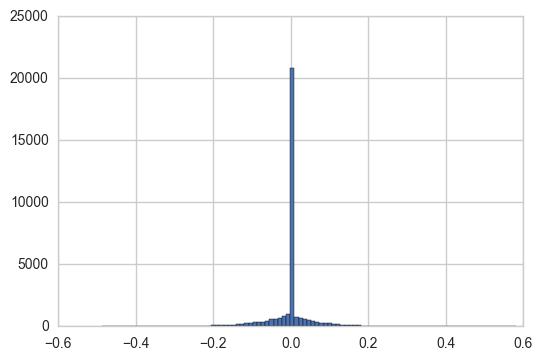

In [60]:
pd.Series(W.values.ravel()).hist(bins=100)

In [61]:
weight_cutoff = .1

In [62]:
W.head()

Drug       17AAG  5FLUOROURACIL  5Z7OXOZEAENOL    681640     AC220  AFATINIB  \
RPPA                                                                           
ABL1    0.160813      -0.000060       0.000013  0.000068  0.000009 -0.076041   
ACACA  -0.000007       0.069429       0.024566  0.000223 -0.000058 -0.045456   
ACVRL1  0.036237      -0.000008       0.002805  0.000036  0.000004 -0.000011   
ADAR    0.000021      -0.060544       0.000004  0.002616 -0.000002 -0.000008   
AKT1   -0.000014       0.016830       0.000107 -0.000057  0.091430 -0.000032   

Drug    AG014699     AICAR  AKTINHIBITORVIII    AMG706    ...      XMD1499  \
RPPA                                                      ...                
ABL1    0.044272  0.096607          0.000002  0.111439    ...    -0.000003   
ACACA  -0.000020 -0.010185         -0.066891  0.000017    ...     0.000010   
ACVRL1 -0.072403 -0.004797          0.088747  0.000018    ...    -0.000006   
ADAR   -0.000008  0.000004          0.000022  0.162846    ...     0.000005   
AKT1   -0.000034  0.089306         -0.043091 -0.000662    ...    -0.000052   

Drug     XMD1527    XMD892        Y39983    YK4279     YM155      YM201636  \
RPPA                                                                         
ABL1   -0.000017  0.000019  2.091986e-05  0.000514 -0.000057  3.589400e-06   
ACACA  -0.000003 -0.009843  7.475280e-06  0.000010  0.000006 -1.081458e-01   
ACVRL1  0.000062 -0.000011 -8.529153e-07  0.000008 -0.000013  2.355989e-05   
ADAR   -0.000001  0.165340  4.592862e-06  0.000005 -0.050335 -6.905096e-07   
AKT1   -0.000047  0.128874 -1.276364e-05 -0.000012  0.000024 -3.253325e-03   

Drug        ZG10  ZM447439   ZSTK474  
RPPA                                  
ABL1    0.000015  0.062005 -0.000026  
ACACA  -0.000063  0.106440 -0.055769  
ACVRL1  0.000009  0.016287 -0.000005  
ADAR   -0.000006  0.000006 -0.000037  
AKT1    0.000006  0.000009  0.000003  

[5 rows x 196 columns]

In [64]:
layout = dict(
    title='RPPA Weights by Predictive Task (ie Drug)',
    width=1000, height=600,
    margin=dict(l=120)
)
fig = W.applymap(lambda v: np.nan if abs(v) <= weight_cutoff else v)\
    .iplot(kind='heatmap', colorscale='Spectral', asFigure=True, layout=layout)
fig['layout']['xaxis'].update(title='RPPA Gene')
fig['layout']['yaxis'].update(title='Drug')
filename = rpath('rppa_weight_all.html')
plty.offline.plt(fig, filename=filename)
print(filename)
plty.offline.iplt(fig)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large/rppa_weight_all.html


In [66]:
layout = dict(
    title='RPPA Weights by Predictive Task (ie Drug)<br>* Highly predictable drugs only',
    width=1000, height=600,
    margin=dict(l=120)
)
fig = W[top_drugs].applymap(lambda v: np.nan if abs(v) < weight_cutoff else v)\
    .iplot(kind='heatmap', colorscale='Spectral', asFigure=True, layout=layout)
fig['layout']['xaxis'].update(title='RPPA Gene')
fig['layout']['yaxis'].update(title='Drug')
filename = rpath('rppa_weight_best.html')
plty.offline.plt(fig, filename=filename)
print(filename)
plty.offline.iplt(fig)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large/rppa_weight_best.html


In [67]:
sorted(top_drugs.values)

['AFATINIB',
 'AP24534',
 'AT7519',
 'AZD7762',
 'BLEOMYCIN50UM',
 'BMS345541',
 'BMS708163',
 'BX795',
 'BX912',
 'CAMPTOTHECIN',
 'CEP701',
 'CETUXIMAB',
 'CH5424802',
 'CHIR99021',
 'CISPLATIN',
 'CP724714',
 'DOCETAXEL',
 'FK866',
 'GSK1070916',
 'GSK1904529A',
 'GSK690693',
 'GW2580',
 'HG511301',
 'IBET762',
 'KIN001055',
 'KIN001102',
 'KIN001236',
 'KIN001270',
 'LENALIDOMIDE',
 'LY317615',
 'MK2206',
 'MLN4924',
 'MPS1IN1',
 'NPK76II721',
 'OLAPARIB',
 'PD0325901',
 'PFI1',
 'PHA793887',
 'PIPERLONGUMINE',
 'QLXII47',
 'RDEA119',
 'RTRAIL',
 'SN38',
 'STF62247',
 'T0901317',
 'TEMOZOLOMIDE',
 'TG101348',
 'THAPSIGARGIN',
 'TPCA1',
 'TRAMETINIB',
 'TUBASTATINA',
 'UNC1215',
 'XAV939',
 'XMD1185H',
 'XMD132',
 'XMD1527',
 'Y39983',
 'YK4279',
 'ZG10',
 'ZM447439',
 'ZSTK474']

## Predictions on Sensitive

'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large2/pred_top_drugs_static.png'

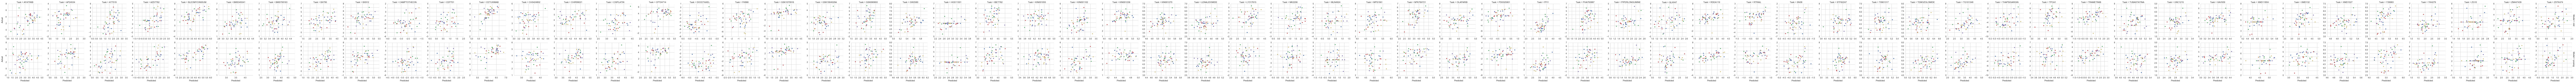

In [118]:
d_plt = d_pred_melt[d_pred_melt['Task'].isin(top_drugs)]
d_plt = d_plt[d_plt['Model'].isin(['pcareg', 'mkl'])]
predictions.visualize(train_res, d_plt, share_axes=False, figsize=3)
filename = rpath('pred_top_drugs_static.png')
plt.savefig(filename)
filename

In [77]:
from plotly.tools import make_subplots
def plot_predictions_for_all_drugs(
    d_pred, top_drugs, model, title, filename=None, 
    n_col=4, sens_thresh=-1, sens_ct=3,
    plot_in_notebook=True):
    
    d = d_pred[d_pred['Task'].isin(top_drugs)]
    d = d[d['Model'] == model]
    
    grps = d.groupby('Task')
    tasks = sorted(list(grps.groups.keys()))
    n_task = len(tasks)
    
    def get_rc(i):
        return (i // n_col) + 1, (i % n_col) + 1
    
    n_row = get_rc(n_task)[0]
    if n_task % n_col == 0:
        n_row -= 1
        
    fig = make_subplots(n_row, n_col, print_grid=False, subplot_titles=tasks)
    fig['layout'].update(width=1000, height=n_row*250)
    fig['layout'].update(title=title)
    
    for i, k in enumerate(tasks):
        g = grps.get_group(k)
        
        is_sens = np.sum(g['Actual'] <= sens_thresh) >= sens_ct
        if is_sens:
            color = 'rgb(214, 39, 40)'
        else:
            color = 'rgb(31, 119, 180)'
            
        trace1 = go.Scatter(
            x=g['Predicted'],
            y=g['Actual'],
            name=k,
            mode='markers',
            marker=dict(color=color),
            showlegend=False
        )
        fig.append_trace(trace1, *get_rc(i))
        
        if is_sens:
            trace2 = go.Scatter(
                x=np.repeat(sens_thresh, 2),
                y=[min(g['Actual'].min(), sens_thresh), max(g['Actual'].max(), sens_thresh)],
                name='Sensitivity Threshold',
                mode='lines',
                line=dict(dash='dash'),
                marker=dict(color='rgb(44, 160, 44)'),
                hoverinfo='x+name',
                showlegend=False,
                opacity=.5
            )
            trace3 = go.Scatter(
                y=np.repeat(sens_thresh, 2),
                x=[min(g['Predicted'].min(), sens_thresh), max(g['Predicted'].max(), sens_thresh)],
                name='Sensitivity Threshold',
                mode='lines',
                line=dict(dash='dash'),
                marker=dict(color='rgb(44, 160, 44)'),
                hoverinfo='y+name',
                showlegend=False,
                opacity=.5
            )
            fig.append_trace(trace2, *get_rc(i))
            fig.append_trace(trace3, *get_rc(i))
        
    if plot_in_notebook:
        plty.offline.iplt(fig)
    if filename is not None:
        filename = rpath(filename)
        plty.offline.plt(fig, filename=filename)
    return filename

In [79]:
title='Predicted vs Actual (PCA Reg Model)<br>(Predicted on x-axis, Actual on y-axis)'
plot_predictions_for_all_drugs(
    d_pred_melt, top_drugs, 'pcareg', title, 
    filename='pred_top_drugs_pcareg.html', plot_in_notebook=False
)

'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large/pred_top_drugs_pcareg.html'

In [29]:
title='Predicted vs Actual (MKL Model)<br>(Predicted on x-axis, Actual on y-axis)'
plot_predictions_for_all_drugs(
    d_pred_melt, top_drugs, 'mkl', title, 
    filename='pred_top_drugs_mkl.html', plot_in_notebook=False
)

'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large2/pred_top_drugs_mkl.html'

In [146]:
# These drugs were selected by looking for negative value predictions in the above

sens_drugs = [
    'TRAMETINIB', 'RTRAIL', 'PD0325901', 'MLN4924', 'AZD7762', 
    'AFATINIB', 'AT7519', 'CAMPTOTHECIN', 'CEP701', 'FK866',
    'DOCETAXEL', 'GSK1070916', 'MK2206', 'SN38',
    'THAPSIGARGIN'
]

title='Predicted vs Actual for Sensitive Drugs Only (MKL Model)<br>(Predicted on x-axis, Actual on y-axis)'
plot_predictions_for_all_drugs(
    d_pred_melt, sens_drugs, 'mkl', title, n_col=5,
    filename='pred_top_drugs_sens_mkl.html', plot_in_notebook=True
)

in


'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large2/pred_top_drugs_sens_mkl.html'

In [119]:
# def plot_single_drug(d, drug, model):
#     d = d[d['Task'] == drug]
#     d = d[d['Model'] == model]
#     trace = go.Scatter(
#         x=d['Predicted'],
#         y=d['Actual'],
#         mode='markers',
#         text=d.reset_index()['CELL_LINE_ID:MGDS']
#     )
#     layout = go.Layout(
#         title='Predictions (Model = "{}", Drug = "{}")'.format(model, drug),
#         hovermode='closest'
#     )
#     fig = go.Figure(data=[trace], layout=layout)
#     filename = rpath('pred_best_{}_{}.html'.format(drug, model))
#     plty.offline.plt(fig, filename=filename)
#     print(filename)
#     plty.offline.iplt(fig)

# sens_drugs = ['TRAMETINIB', 'RTRAIL', 'PD0325901', 'MLN4924', 'AZD7762']

# for drug in sens_drugs:
#     plot_single_drug(d_pred_melt, drug, 'mkl')
    

### Weights for Sensitive and Predictable Drugs

In [71]:
layout = dict(
    title='RPPA Weights by Predictive Task (ie Drug)<br>* Predictable AND sensitive drugs',
    width=1000, height=400,
    margin=dict(l=120)
)
fig = W[sens_drugs].applymap(lambda v: np.nan if abs(v) < weight_cutoff else v)\
    .iplot(kind='heatmap', colorscale='Spectral', asFigure=True, layout=layout)
    
fig['layout']['xaxis'].update(title='RPPA Gene')
fig['layout']['yaxis'].update(title='Drug')

filename = rpath('rppa_weight_best_and_sensitive.html')
plty.offline.plt(fig, filename=filename)
print(filename)
plty.offline.iplt(fig)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large/rppa_weight_best_and_sensitive.html


# KL Comparison to Other Methods

In [51]:
def get_coef_array(multi_est):
    d_coef = []
    for est in multi_est.estimators_:
        d_coef.append(est.coef_)
    return pd.DataFrame(d_coef, index=Y_drug.columns, columns=X_drug.columns)

### Lasso

In [100]:
# from ml.api.results import properties
# est = properties.extract_refit_model_map(train_res)['lasso']

# d_coef = get_coef_array(est.clf.named_steps['est'])
# d_coef.head()

In [101]:
# has_pos = d_coef.abs().sum(axis=0)
# d_coef_top = d_coef[list(has_pos[has_pos > 0].index.values)]
# print(d_coef_top.shape)
# layout = dict(
#     title='Lasso Coefficients on Most Predictable Drugs',
#     margin=dict(l=100)
# )
# fig = d_coef_top.T.applymap(lambda v: np.nan if np.isclose(v, 0) else v)\
#     .iplot(kind='heatmap', colorscale='Spectral', asFigure=True, layout=layout)
# plty.offline.iplt(fig)
# filename = rpath('lasso_weight.html')
# plty.offline.plt(fig, filename=filename)
# print(filename)

### Ridge

In [52]:
from ml.api.results import properties
est = properties.extract_refit_model_map(train_res)['ridge']

d_coef = get_coef_array(est.clf.named_steps['est'])
d_coef.head()

A1BG       A2M     A2ML1    A4GALT     A4GNT      AAAS  \
Task                                                                        
17AAG         -0.000162  0.000465  0.000144 -0.000177 -0.000359 -0.000420   
5FLUOROURACIL -0.000632  0.001117 -0.002069  0.000452  0.000394  0.000252   
5Z7OXOZEAENOL  0.000692 -0.000194  0.000072 -0.000008 -0.000921 -0.000627   
681640        -0.000277 -0.000323  0.000187  0.000087 -0.000354  0.000072   
AC220          0.000058 -0.001522  0.000346  0.000373 -0.000269  0.000264   

                   AACS     AADAC   AADACL2     AADAT    ...       ZSWIM7  \
Task                                                     ...                
17AAG          0.000093 -0.000336  0.000127 -0.000563    ...     0.000200   
5FLUOROURACIL  0.000122 -0.000677  0.000754  0.001387    ...    -0.000259   
5Z7OXOZEAENOL  0.000143 -0.000062 -0.000086 -0.000254    ...     0.000083   
681640        -0.000261 -0.000383  0.000380 -0.000400    ...    -0.000334   
AC220         -0.000151 -0.000497  0.000243 -0.000252    ...    -0.000535   

                 ZSWIM8     ZUFSP     ZWINT      ZXDC    ZYG11A    ZYG11B  \
Task                                                                        
17AAG         -0.000194 -0.000886  0.000556 -0.001163  0.000608 -0.000278   
5FLUOROURACIL -0.000035  0.000625  0.000181  0.000877 -0.001238 -0.000481   
5Z7OXOZEAENOL -0.000055 -0.000397 -0.000302 -0.000467  0.000498  0.000093   
681640         0.000418 -0.000220 -0.000320 -0.000043  0.000174 -0.000033   
AC220         -0.001433  0.000197 -0.000168 -0.000143 -0.000046 -0.001114   

                    ZYX     ZZEF1      ZZZ3  
Task                                         
17AAG         -0.000143 -0.000508  0.000163  
5FLUOROURACIL  0.001059  0.002393 -0.000237  
5Z7OXOZEAENOL -0.000126  0.000082 -0.000305  
681640        -0.000058 -0.000153 -0.000221  
AC220         -0.000133  0.000380  0.000286  

[5 rows x 13415 columns]

In [57]:
mean_coef = d_coef.abs().mean(axis=0).sort_values(ascending=False)
d_coef_top = d_coef[list(mean_coef.head(500).index.values)]
layout = dict(
    title='Ridge Coefficients on Most Predictable Drugs',
    margin=dict(l=100)
)
fig = d_coef_top.T.applymap(lambda v: np.nan if np.isclose(v, 0) else v)\
    .iplot(kind='heatmap', colorscale='Spectral', asFigure=True, layout=layout)
fig['layout']['xaxis'].update(title='Gene')
fig['layout']['yaxis'].update(title='Drug')
plty.offline.iplt(fig)
filename = rpath('ridge_weight.html')
plty.offline.plt(fig, filename=filename)
print(filename)

/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/breast_cancer/cv_large/ridge_weight.html


# Graveyard

In [175]:
#known_drugs = ['']
# W['NUTLIN3A'].abs().sort_values().tail(25)
# W['AG014699'].abs().sort_values().tail(25)
# W['PLX4720'].abs().sort_values().tail(25)
# W['SB590885'].abs().sort_values().tail(25)
#W['PD0332991'].abs().sort_values().tail(25)
#W['PLX4720'].abs().sort_values().tail(25)
